In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from IPython import display
import control
from collections import deque
import pickle
from Tools.ExtKalmanFilter import *
from Tools.sqrtm import sqrtm
from Tools.Models_Buffers_More import *
from RL_algorithms.DDPG import ddpg
from ExampleModels.Dynamics_dbl_integrators import *
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deviceCPU = torch.device("cpu")
print(device, deviceCPU)

cpu cpu


In [22]:
# Figures parameters
saveFigs = True
FigDim1 = 3.0
FigDim2 = 1.5

# Noise parameters Cov(w), Cov(v), respectively
Q = 0.5 * torch.diag(1.0 * torch.ones(rx,)) #Filter covariance (typically is larger than true)
Q_true = 0.1 * Q                            #True covariance
R = 0.1 * torch.diag(1.0 * torch.ones(ry,))

# Linearized dynamic system:
x_linearization = torch.tensor([[0, 0, 1, 1, 1, 1]], dtype = torch.float64).T
A, B = torch.autograd.functional.jacobian(stateDynamics,
                         inputs=(x_linearization, torch.zeros(ru, 1)))
A = torch.atleast_2d(A.squeeze())
B = torch.atleast_2d(B.squeeze()).T

# LQR design params
Q_lqr = torch.diag(1.0 * torch.ones(rx,))
Q_lqr[2:6, 2:6] = 0.0
R_lqr = torch.diag(1.0 * torch.ones(ru,))
Klqr, _, _ = control.dlqr(torch.tensor([[1, 1],[0, 1]]), torch.tensor([[0, 1]]).T, torch.tensor([[1,0],[0,1]]), torch.tensor([1]))
#Klqr, _, _ = control.dlqr(A, B, Q_lqr, R_lqr)
Klqr = - torch.from_numpy(Klqr)
Klqr = torch.cat((Klqr,torch.zeros(1,4)), dim=1)
Klqr_hyperstate = torch.cat((Klqr,torch.zeros(1,rx)), dim=1)
# Define model object to be used by the extended Kalman filter
model = Model(stateDynamics, measurementDynamics, f_Jacobian, g_Jacobian, Q, R)

# Define information state: (mean, covariance), from an extended Kalman Fitler.
x0=torch.randn(rx, 1)
P0=torch.diag(torch.ones(rx,))
Hyperstate = Extended_KF(x0, P0, model)

In [28]:
# Reinforcement learning infastructure and warmstart
hidden_dim = 64
actor_lr = 1e-5# * 10
critic_lr = actor_lr * 10# * 100
batch_size = 32#Horizon_Length# * RollOuts
gamma = 0.95


RL_agent = ddpg(rx * 2,ru, hidden_dim, critic_lr, actor_lr, 
                buffer_size = batch_size * 64, tau=0.05, gamma=gamma, device=device)
epochs = 5000
miniBatch = 32
for j in range(epochs):
    training_states = 50 * (torch.rand(miniBatch, rx * 2)-0.5)
    training_states[:, 2:6] = 1 + 0.2 * torch.randn(miniBatch, 4)
    training_states[:, 6:12] = 5 * torch.rand(miniBatch, 6)
    target_actions = training_states @ Klqr_hyperstate.T
    RL_agent.warmstart_actor(training_states, target_actions)



tensor(406.8037)
tensor(447.9020)
tensor(339.7318)
tensor(339.6663)
tensor(374.9100)
tensor(344.6837)
tensor(372.3804)
tensor(352.9310)
tensor(349.9865)
tensor(320.1808)
tensor(379.8440)
tensor(422.6297)
tensor(331.7644)
tensor(412.6274)
tensor(386.4215)
tensor(321.6233)
tensor(345.4887)
tensor(344.0303)
tensor(403.2104)
tensor(339.4430)
tensor(330.4350)
tensor(312.6168)
tensor(286.7722)
tensor(315.4764)
tensor(350.4492)
tensor(271.5775)
tensor(431.0862)
tensor(322.3941)
tensor(363.7558)
tensor(389.1596)
tensor(333.0652)
tensor(410.4953)
tensor(321.1963)
tensor(364.2395)
tensor(357.5672)
tensor(362.4485)
tensor(297.9705)
tensor(281.4053)
tensor(335.1414)
tensor(393.1564)
tensor(297.8400)
tensor(443.8087)
tensor(383.6938)
tensor(390.4025)
tensor(449.0346)
tensor(354.7253)
tensor(315.8679)
tensor(316.4651)
tensor(342.9512)
tensor(359.9558)
tensor(349.1318)
tensor(376.2653)
tensor(380.8226)
tensor(451.0427)
tensor(400.4964)
tensor(463.9005)
tensor(381.1946)
tensor(340.5025)
tensor(325.167

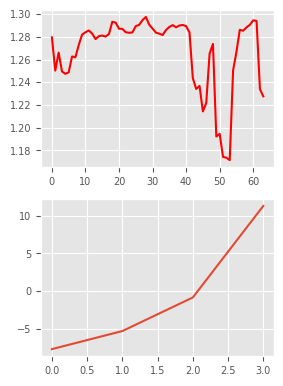

KeyboardInterrupt: 

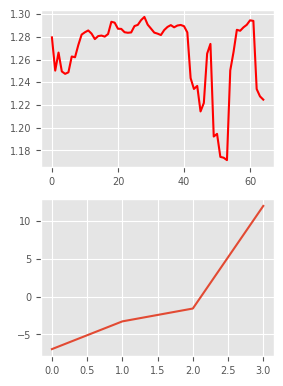

In [30]:
Horizon_Length = 4
NumberOf_Episodes = 1000
actor_lr = 1e-5# * 10
critic_lr = actor_lr * 10# * 100
RL_agent.actor_lr = actor_lr
RL_agent.critic_lr = critic_lr
RollOuts = 1
EffectiveHorizonLength = (1 - gamma ** Horizon_Length) / (1 - gamma)
max_stageCost = 1e4
rewards = []
avg_rewards = []
fig= plt.figure(figsize=(FigDim1,3 * FigDim2))
plt.style.use('ggplot')
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('episode number', fontsize=9)  
plt.ylabel('normalized reward', fontsize=9) 

for episode in range(NumberOf_Episodes):
    episode_reward = 0
    xx_rec = []
    Exploration_std = (NumberOf_Episodes - episode) / NumberOf_Episodes
    for trail in range(RollOuts):
        # Initial conditions of this rollout
        Cov0 = 0.1 * torch.diag(torch.rand(rx,))
        #Cov0[1,1] = 0.5 * torch.rand(1,)
        x0 = 5 * torch.randn(rx, 1)
        x0[2:6] = 1 + 0.1 * torch.randn(4, 1)
        Hyperstate.ChangeInitialStates(x0, Cov0)
        # Horizon of this rollout
        true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step
        for k in range(Horizon_Length):
            state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1).to(device)
            action = RL_agent.get_action(state)
            action = Exploration_std * torch.randn(ru,) + action
            action = action.to(deviceCPU)
            action = action.T
            # Adding some exploration effort
            action = torch.atleast_2d(action).detach()
            # Create a transition
            
            true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
            measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
            # reward function
            reward = rewardFunction1(Hyperstate.Mean, Hyperstate.Covariance, action, Q_lqr, R_lqr, max_stageCost, true_state)
            Test_Magnitudes = torch.cat((state, action), dim=1)
            if ((Test_Magnitudes.abs() > 10000).sum() > 0):
                reward = -100
                print('Failure')
                break
            # Advance to next hyperstate
            Hyperstate.ApplyEKF(action, measurement_Plus_realization)
            new_state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1)
            RL_agent.Buffer.push(state, action.T, reward, new_state)
            state = new_state
            episode_reward += reward * gamma ** k
            true_state = true_state_Plus
            xx_rec.append(Hyperstate.Mean[0].detach().numpy())
    if len(RL_agent.Buffer)>= batch_size:
        for jjj in  range(8):
            RL_agent.train_critic(batch_size)
        for jjj in  range(1):
            RL_agent.train_actor(batch_size*1) 
    
    EffectiveHorizonLength = (1 - gamma ** k) / (1 - gamma)
    rewards.append(episode_reward.numpy() / (EffectiveHorizonLength * RollOuts))
    avg_rewards.append(np.mean(rewards[-5:]))


    if (True):
        plt.clf()
        plt.subplot(2, 1, 1)
        plt.plot(avg_rewards, 'r')
        plt.subplot(2, 1, 2)
        plt.plot(xx_rec)
        display.clear_output(wait=True)
        display.display(plt.gcf())
    



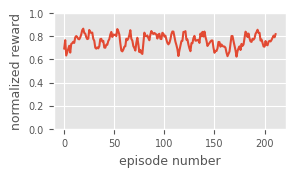

FileNotFoundError: [Errno 2] No such file or directory: 'Data/StateFeedbackGainFunction.pkl'

In [14]:
plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('episode number', fontsize=9)  
plt.ylabel('normalized reward', fontsize=9) 
plt.plot(avg_rewards)
plt.ylim([0.0, 1])
if saveFigs==True:
    plt.savefig('Figures/Example1_avgReward.pdf',bbox_inches ="tight")
plt.show()


K = RL_agent.get_action#get_action

with open('Data/StateFeedbackGainFunction.pkl', 'wb') as outp:
    pickle.dump(K, outp, pickle.HIGHEST_PROTOCOL)

#with open('StateFeedbackGainFunction.pkl', 'rb') as inp:
    #K1 = pickle.load(inp)

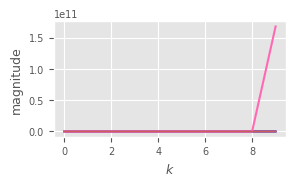

In [21]:
T = 10

StateRec = deque([])
CovRec = deque([])
ActionRec = deque([])
StateRec_true = deque([])
Cov0 = 1 * torch.diag(torch.rand(rx,))
x0 = 1 * torch.randn(rx, 1)
Hyperstate.ChangeInitialStates(x0, Cov0)
true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step


for k in range(T):
    state = torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1)
    action = K(state)
    action = torch.atleast_2d(action.detach()).T
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
    StateRec.append(Hyperstate.Mean)
    CovRec.append(Hyperstate.Covariance)
    ActionRec.append(action)
    StateRec_true.append(true_state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
x = np.ones((rx, T))
x_true = np.ones((rx, T))
P = np.ones((rx ** 2, T))
for i in range(T):
    x[:,i] = StateRec[i].detach().numpy().squeeze()
    x_true[:,i] = StateRec_true[i].detach().numpy().squeeze()
    P[:,i] = CovRec[i].detach().numpy().squeeze().flatten()

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 

k=56
plt.plot(range(T), x[0,:], color=list(colors.cnames)[k+4])
plt.plot(range(T), P[0,:], color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true[0,:], linewidth = 1, color=list(colors.cnames)[k+3])

if saveFigs==True:
   plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


In [ ]:
T = 15

StateRec = deque([])
ActionRec = deque([])
StateRec_true = deque([])
Cov0 = 10 * torch.diag(torch.rand(rx,))
x0 = 10 * torch.randn(rx, 1)
Hyperstate.ChangeInitialStates(x0, Cov0)
true_state = Hyperstate.Mean + sqrtm(Hyperstate.Covariance) @ torch.randn(rx, 1) #we might need next t-step

for k in range(T):
    action = torch.from_numpy(-Klqr) @ Hyperstate.Mean
    action = torch.atleast_2d(action.detach())
    true_state_Plus = stateDynamics(true_state, action) + sqrtm(Q_true) @ torch.randn(rx, 1)
    measurement_Plus_realization = measurementDynamics(true_state_Plus, action) + sqrtm(R) @ torch.randn(ry, 1)
    StateRec.append(Hyperstate.Mean)
    ActionRec.append(action)
    StateRec_true.append(true_state)
    Hyperstate.ApplyEKF(action, measurement_Plus_realization)
    true_state = true_state_Plus
x = np.ones((rx, T))
x_true = np.ones((rx, T))
for i in range(T):
    x[:,i] = StateRec[i].detach().numpy().squeeze()
    x_true[:,i] = StateRec_true[i].detach().numpy().squeeze()

plt.style.use('ggplot')
fig= plt.figure(figsize=(FigDim1,FigDim2))
plt.rc('xtick', labelsize=7) #fontsize of the x tick labels
plt.rc('ytick', labelsize=7) #fontsize of the y tick labels
plt.xlabel('$k$', fontsize=9)  
plt.ylabel('magnitude', fontsize=9) 

k=56
plt.plot(range(T), x[0,:], color=list(colors.cnames)[k+4])
#plt.plot(range(T), P, color=list(colors.cnames)[k+2])
plt.plot(range(T), x_true[0,:], linewidth = 1, color=list(colors.cnames)[k+3])

if saveFigs==True:
   plt.savefig('Figures/Example1_ReinfLearn.pdf',bbox_inches ="tight")


NameError: name 'Klqr' is not defined

In [ ]:
print(StateRec[0].detach().numpy())

In [ ]:
u = torch.tensor([[1.0],[2.0]])
x = torch.tensor([[5.0, 1.0, 3.2]]).T
print(x[0])
print(stateDynamics(x, u))
print(f_Jacobian(x, u).trace())

In [ ]:
A = torch.tensor([[0.9, 0, 0],
                  [-0.05, 0.8, 0],
                  [-0.2, 0, 0.95]])
L, V = torch.linalg.eig(A)
print(L)

In [ ]:
print(torch.diag(Hyperstate.Covariance).unsqueeze(0))
print(Hyperstate.Mean.T)
print(torch.cat((Hyperstate.Mean.T, torch.diag(Hyperstate.Covariance).unsqueeze(0)), dim=1))

In [ ]:
Hyperstate.Covariance = Hyperstate.Covariance + -0.001
print(Hyperstate.Covariance)
sqrtm(Hyperstate.Covariance @ Hyperstate.Covariance)

In [ ]:
rx = 3
torch.zeros(rx, 1)